In [2]:
from sklearn.model_selection import train_test_split # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore

import datetime
import os
import numpy as np # type: ignore
import tensorflow as tf # type: ignore

In [7]:
# path for saving the data (numpy array)
DATA_PATH = os.path.join("../datasets")

# sign action to be detected
ACTIONS = np.array(
    [
        "hello",
        "thanks",
        "i-love-you",
        "see-you-later",
        "I",
        "Father",
        "Mother",
        "Yes",
        "No",
        "Help",
        "Please",
        "Want",
        "What",
        "Again",
        "Eat",
        "Milk",
        "More",
        "Go To",
        "Bathroom",
        "Fine",
        "Like",
        "Learn",
        "Sign",
        "Done",
    ]
)

# NOTE: use the first 6 since we only have 6 label only for now
ACTIONS = ACTIONS[:12]

# x videos worth of data (per label)
videos_per_label = np.max(np.array(os.listdir(os.path.join(DATA_PATH, ACTIONS[0]))).astype(int)) + 1

# 30 action per videos
# NOTE: This does not affect how much the frame is
action_per_video = 30

In [8]:
ACTIONS

array(['hello', 'thanks', 'i-love-you', 'see-you-later', 'I', 'Father',
       'Mother', 'Yes', 'No', 'Help', 'Please', 'Want'], dtype='<U13')

In [9]:
# output example:
# {'hello': 0, 'thanks': 1, 'i-love-you': 2, ...}
labels_map = {label: index for index, label in enumerate(ACTIONS)}

sequences, labels = [], []

In [10]:
labels_map, videos_per_label

({'hello': 0,
  'thanks': 1,
  'i-love-you': 2,
  'see-you-later': 3,
  'I': 4,
  'Father': 5,
  'Mother': 6,
  'Yes': 7,
  'No': 8,
  'Help': 9,
  'Please': 10,
  'Want': 11},
 60)

In [11]:
"""
Iterates over each action in the ACTIONS list.

For each action, it will process multiple sequences of frames.
"""
for action in ACTIONS:

    """Iterates over each sequence for the current action"""
    for sequence in range(videos_per_label):
        # empty list (window) to hold the frames of the current sequence.
        sequence_actions = []

        """
        Frame Processing

        Iterates over each frame in the current sequence, then constructs the file path to the numpy array for the current frame.
        Prints the path to verify correctness, then loads the frame data from the numpy file.
        """
        for frame_num in range(action_per_video):
            # construct the path to the numpy file for the current frame
            npy_path = os.path.join(
                DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)
            )

            # load the frame data from the numpy file
            result = np.load(npy_path)

            # append the frame data to the current sequence (window)
            sequence_actions.append(result)

        # append the completed sequence to the sequences list
        sequences.append(sequence_actions)

        # append the corresponding label to the labels list
        labels.append(labels_map[action])

In [12]:
len(sequences)

720

Convert the sequences and labels lists into NumPy arrays that are suitable for use as input (X) and output (y) in machine learning models, particularly for deep learning models.

In [13]:
X = np.array(sequences)

# convert labels list to a one-hot encoded NumPy array
y = to_categorical(labels).astype(int)

In [14]:
len(X), len(y)

(720, 720)

In [15]:
# splits the dataset into training and testing sets
# specifies that 10% of the data should be used as the test set, and the remaining 90% should be used as the training set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

The shapes of the datasets depend on the total number of sequences and the sequence length. Assuming the code processes 60 sequences for each of the 3 actions, we have:

    Total sequences = 60 sequences/action × 6 actions = 360 sequences

Given a test_size of 0.2, 20% of the data (approximately 72 sequences) will be in the test set, and 80% (approximately 288 sequences) will be in the training set.

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((576, 30, 1692), (144, 30, 1692), (576, 12), (144, 12))

#### Modelling

In [17]:
from tensorflow.keras.models import Sequential, save_model  # type: ignore
from tensorflow.keras.layers import BatchNormalization, Conv1D, MaxPooling1D, Dense, Dropout, LSTM, Bidirectional  # type: ignore
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau  # type: ignore
from tensorflow.keras.regularizers import l2  # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

In [18]:
# the input shape (30, 1692) where 30 is the sequence length and 1692 is the number of features per frame
input_shape = (30, 1692)

Topic regarding TimeDistributed

- https://stackoverflow.com/a/76796778/14182545
- https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

    Another kind of layer that is the famous "LSTM" (or GRU). It is not mandatory but it will finalize the chronological resolution of inputs.

    Dense without TimeDistributed computes perBatch.
    TimeDistributed with Dense computes per Timestep.

#### Model Architecture CNN-LSTM_1L

In [19]:
# asl-action-cnn-lstm_1l-2.9M
tf.keras.backend.clear_session()

model = Sequential()

# data normalization
model.add(BatchNormalization(input_shape=input_shape))

# first Conv1D layer with L2 regularization
model.add(
    Conv1D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=l2(0.01))
)  # changed kernel size and filters
model.add(MaxPooling1D(pool_size=2))

# second Conv1D layer with L2 regularization
model.add(
    Conv1D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=l2(0.01))
)  # changed kernel size and filters
model.add(MaxPooling1D(pool_size=2))

# third Conv1D layer with L2 regularization
model.add(
    Conv1D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=l2(0.01))
)  # changed kernel size and filters
model.add(MaxPooling1D(pool_size=2))

# dense layer for feature extraction with L2 regularization
model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# bidirectional LSTM layer with L2 regularization
model.add(
    Bidirectional(
        LSTM(512, return_sequences=False, activation="relu", kernel_regularizer=l2(0.01))
    )
)

# dense layers for classification with dropout for regularization
model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # slightly higher dropout rate, so it's not overfitting
model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # slightly higher dropout rate, so it's not overfitting

model.add(Dense(ACTIONS.shape[0], activation="softmax"))

c:\Users\user\OneDrive\DOKUMEN\JO\myenv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 30, 1692)       │         6,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 28, 64)         │       324,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1024)           │     2,363,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,975,036 (11.35 MB)

 Trainable params: 2,971,652 (11.34 MB)

 Non-trainable params: 3,384 (13.22 KB)

#### Setting Up

In [22]:
def create_log_dir(base_dir, use_time=False):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # check existing log directories
    existing_logs = [
        d
        for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("train-")
    ]

    # determine the new log directory name
    if existing_logs and not use_time:
        latest_log = max(existing_logs)
        log_num = int(latest_log.split("-")[1]) + 1
        new_log_dir = os.path.join(base_dir, f"train-{str(log_num).zfill(3)}")

    if not existing_logs and not use_time:
        new_log_dir = os.path.join(base_dir, f"train-001")

    if use_time:
        new_log_dir = os.path.join(base_dir, f"train-{current_time}")

    # create the new log directory
    os.makedirs(new_log_dir)
    print(f"Created new log directory: {new_log_dir}")

    return new_log_dir

In [23]:
from tensorflow.keras.callbacks import Callback  # type: ignore


class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor="val_loss", value=0.001, verbose=0, patience=20):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            raise ValueError(f"Early stopping requires {self.monitor} available!")

        if current <= self.value:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose > 0:
                    print(
                        f"Epoch {epoch}: early stopping threshold reached with {self.monitor} = {current}"
                    )
                self.model.stop_training = True
        else:
            self.wait = 0  # reset wait if the condition is not met

#### Compiling

In [24]:
# set the optimizer with an initial learning rate
optimizer = Adam(learning_rate=1e-4)

# compile the model with the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

"""
Define the EarlyStopping callback with adjusted patience

monitor  : monitor the `val_loss` for training.
patience : sets the number of epochs to wait for an improvement,
           in the monitored metric before stopping the training.
           `patience=10` means that if the validation loss does not improve for 10 consecutive epochs,
           the training will be stopped.
"""
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

early_stopping_by_loss_val = EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1, patience=20)

"""
Define the ReduceLROnPlateau callback with adjusted factor and patience

monitor  : monitor the `val_loss` for training.
factor   : which the learning rate will be reduced. A factor=0.5 means the
           learning rate will be halved when the metric has stopped improving.
patience : sets the number of epochs with no improvement after which the learning rate will be reduced.
           `patience=10` means if the validation loss does not improve for 10 consecutive epochs,
           the learning rate will be reduced.
min_lr   : lower bound on the learning rate, learning rate will not be reduced below `0.00001`,
           ensuring it doesn't become too small.
"""
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

#### Training

In [27]:
tf.keras.backend.clear_session()

# TensorBoard callback for logging
log_dir = os.path.join(create_log_dir(os.path.join("../logs"), True))

tensor_board_cb = TensorBoard(log_dir=log_dir)

# train the model with the callbacks
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=[tensor_board_cb, early_stopping, early_stopping_by_loss_val, reduce_lr],
    batch_size=32,
)

Created new log directory: ../logs\train-20240610-020002
Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.0908 - loss: 12.7567 - val_accuracy: 0.0764 - val_loss: 12.2670 - learning_rate: 1.0000e-04
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.1093 - loss: 12.0840 - val_accuracy: 0.1319 - val_loss: 11.6610 - learning_rate: 1.0000e-04
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.1093 - loss: 11.4462 - val_accuracy: 0.0764 - val_loss: 11.0965 - learning_rate: 1.0000e-04
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.1443 - loss: 10.8822 - val_accuracy: 0.0833 - val_loss: 10.5944 - learning_rate: 1.0000e-04
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.1634 - loss: 10.3712 - val_accuracy: 0.1042 - val_loss: 10.1431 - learning_rate: 1.0000e-04
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.1654 - loss: 9.9072 - val_accuracy: 0.1597 - val_loss: 9.7029 - learning_rate: 1

#### Saving The Trained Model

In [28]:
def get_next_filename(directory, base_name, extension):
    # list all files in the directory
    files = os.listdir(directory)
    # filter files that start with the base_name and end with the extension
    relevant_files = [
        f for f in files if f.startswith(base_name) and f.endswith(extension)
    ]

    if not relevant_files and base_name == "asl-action-weight":
        # if no relevant files found, start with 001
        return f"{base_name}-001.{extension}"

    if not base_name == "asl-action-weight":
        return f"{base_name}.{extension}"

    # extract the numeric part and find the highest number
    numbers = [int(f[len(base_name) + 1 : -len(extension) - 1]) for f in relevant_files]
    next_number = max(numbers) + 1

    # format the next number with leading zeros to maintain the same length
    next_filename = f"{base_name}-{next_number:03d}.{extension}"
    return next_filename


def model_save(
    model, directory="../models/legacy", base_name="asl-action-weight", extension="h5"
):
    next_filename = get_next_filename(directory, base_name, extension)
    model_path = os.path.join(directory, next_filename)

    if extension == "tflite":
        converter = tf.lite.TFLiteConverter.from_keras_model(model)

        # See issue here:
        # - https://github.com/tensorflow/tensorflow/issues/26869
        # - https://github.com/tensorflow/tensorflow/issues/26869#issuecomment-474984631
        # - https://github.com/tensorflow/tensorflow/issues/61662
        # - https://stackoverflow.com/a/67252118/14182545
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
            tf.lite.OpsSet.SELECT_TF_OPS,  # enable TensorFlow ops.
        ]

        tflite_model = converter.convert()

        with open(model_path, "wb") as f:
            f.write(tflite_model)

        f.close()

        print(f"Model saved as {next_filename}")
        return

    save_model(model, model_path)

    print(f"Model saved as {next_filename}")

In [32]:
model_save(model, directory="../models/keras", base_name="asl-action-cnn-lstm_1l-6a-es_p30__rlr_f05_p10_lr1e4-2.9M", extension="keras")
model_save(model, directory="../models/legacy", base_name="asl-action-cnn-lstm_1l-6a-es_p30__rlr_f05_p10_lr1e4-2.9M", extension="h5")

Model saved as asl-action-cnn-lstm_1l-6a-es_p30__rlr_f05_p10_lr1e4-2.9M.keras
Model saved as asl-action-cnn-lstm_1l-6a-es_p30__rlr_f05_p10_lr1e4-2.9M.h5


In [34]:
%pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


#### Evaluate

In [37]:
import itertools
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.metrics import confusion_matrix, accuracy_score # type: ignore

In [38]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


Accuracy Score: 0.9513888888888888


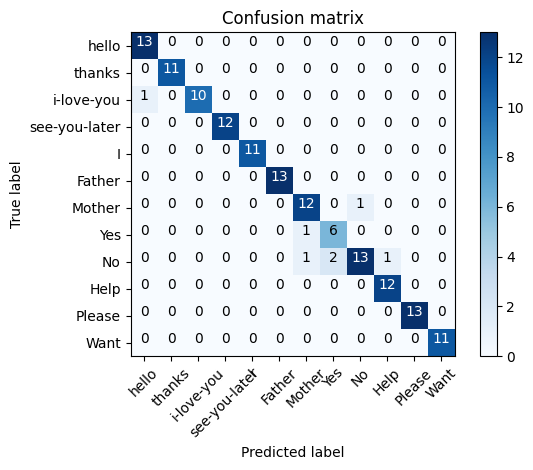

In [39]:
# plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(ACTIONS))
plt.xticks(tick_marks, ACTIONS, rotation=45)
plt.yticks(tick_marks, ACTIONS)

# add labels
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# compute and print accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy Score:", accuracy)

plt.show()